# Marked processes #

We shall be interested in spatial processes which occur in time.

- For example, we might wish to model a self-exciting process where events occur at a location in (2 or 3 dimensional) space, and the "offspring" events show a clustering behaviour close to the parent event.

The standard way of treating such a process is via "marks".  We start with a temporal process as already discussed, and to each event we also associate a "mark" from a "mark space".

- Our mark space will be $\mathbb R^2$, or a subset thereof, i.e. a 2 dimensional point in space.
- Marks can also be discrete, for example to classify events into a number of different types.

We shall consider a restricted setup.  Marks may occur in a "mark space" $M$ (probably $M\subseteq \mathbb R^2$).

- Immigrants will have independently chosen marks, say with density $\gamma(\kappa,t)$.
- The immigrant intensity may vary with time, $\mu(t)$.
- Offspring intensity is $\alpha(\kappa) \beta(t,\kappa)$ where $\alpha$ is the "total intensity" depending on the mark, and $\beta$ is taken to be a normalised intensity, depending on time and the mark.
- The offspring marks are independent and only depend upon the time and mark of the parent.

Thus the total intensity function is
$$ \lambda^*(t) = \mu(t) + \sum_{t_i < t} \alpha(\kappa_i) \beta(t-t_i,\kappa_i). $$

An example of an ETAS (epidemic type aftershock) model has mark space consisting of triples $\kappa=(m,x,y)$ where $m>0$ is the "magnitude" of the event, and $(x,y)$ are coordinates in a window $W$.

- $\mu(t) = \mu_1$ for $t\geq 0$.  So background intensity is constant.
- $\alpha(\kappa) = \alpha_1 e^{m \alpha_2}$.  So the total intensity is exponential in the magnitude.
- $\beta(t,\kappa) = \beta(t)$ is some decaying function in $t$.  For example, a power law
$$ \beta(t) = \frac{\beta_2}{\beta_1} \Big( 1+\frac{t}{\beta_1} \Big)^{-\beta_2-1} $$
where we scale by $\beta_1$, and decay at rate $\beta_2$, and normalise.  Notice that this example is independant of the mark.
- For immigrants we have mark density $\gamma_1 e^{-\gamma_1 m} |W|^{-1}$ for $(x,y)\in W$.  So the coordinates of events are uniform in $W$, and the magnitude follows an exponential distribution.
- For offspring, we have a more complicated mark density:
$$ \gamma(\kappa | t, (t_p,\kappa_p)) = \gamma_1 e^{-\gamma_1 m} \frac{1}{2\pi\gamma_2^2}
\exp\Big( - \frac{\| (x,y) - (x_p,y_p) \|^2}{2\gamma_2^2} \Big) $$
where the parent event occurred at time $t_p$ with mark $\kappa_p$.  Thus the magnitude continues to follow an exponential distribution, but the location of the "aftershock" follows a Gaussian distribution centred on the location of the parent event.

Here we have followed [Rasmussen, "Bayesian Inference for Hawkes Processes"](https://doi.org/10.1007/s11009-011-9272-5).

This approach via "marks" may seem complicated, but it allows us to easily adapt the simulation procedure from the unmarked case, by simply adding in the marks.

Let us consider a one dimensional mark space, which is easier to visualise.

- $\mu(t) = \mu$
- $\alpha(\kappa)=\alpha$
- $\beta(t,\kappa) = (1+t)^{-2}$
- Immigrants will have mark uniformly chosen in $[0,1]$
- Offspring have mark density following a Gaussian centred on the parent location, say with variance $\sigma^2$.

In [235]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import utils

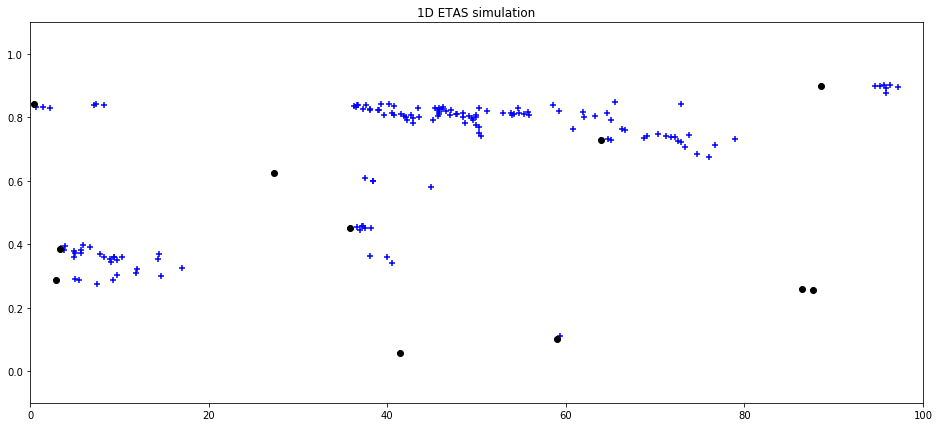

In [304]:
from collections import namedtuple
Event = namedtuple("Event", ["t", "loc"])

mu = 0.1
alpha = 1
sigma = 0.01

def sort_with_causes(points, caused_by):
    """Sorts `points` in time order, and maintains caused by information"""
    # caused_by[i] = j<i if i caused by j, or i if i background
    tagged = list(enumerate(points))
    tagged.sort(key = lambda pair : pair[1].t)
    new_caused_by = []
    for old_index, event in tagged:
        old_cause_index = caused_by[old_index]
        new_cause_index,_ = next(x for x in enumerate(tagged) if x[1][0] == old_cause_index)
        new_caused_by.append(new_cause_index)
    events = [x[1] for x in tagged]
    return events, new_caused_by

def simulate_sub_process(parent : Event):
    points = []
    t = 0
    while True:
        t += np.random.exponential()
        if t >= alpha:
            return points
        loc = np.random.normal(loc=parent.loc, scale=sigma)
        points.append(Event(parent.t + t / (alpha - t), loc))
    
def simulate(window_size=100):
    backgrounds = utils.sample_poisson_process(window_size, 1/mu)
    backgrounds = [Event(t, np.random.uniform()) for t in backgrounds]
    points = list(backgrounds)
    caused_by = [ i for i in range(len(points)) ]
    to_process = [(i,p) for i, p in enumerate(points)]
    while len(to_process) > 0:
        (index, next_point) = to_process.pop()
        for event in simulate_sub_process(next_point):
            if event.t < window_size:
                points.append(event)
                caused_by.append(index)
                to_process.append((len(points) - 1,event))
    points, caused_by = sort_with_causes(points, caused_by)
    return points, backgrounds, caused_by

points, backgrounds, caused_by = simulate()
width, _ = utils.slim_aspect()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width,7))
ax.set(xlim=[0,100], ylim=[-0.1,1.1], title="1D ETAS simulation")
_ = ax.scatter(x=[e.t for e in points], y=[e.loc for e in points], color="blue", marker="+")
_ = ax.scatter(x=[e.t for e in backgrounds], y=[e.loc for e in backgrounds], color="black")

In this example, we have set the background rate to be low, and the mark distribution of offspring to be tightly bound to the location of the parent.  This allows us to visualise how an immigrant sets off a chain of "aftershocks" which spread out slowly in space.

# Model extraction #

Let us start by assuming we know the form, and parameters, of the distributions.  We aim then to classify points as "background" or "triggered by another point".  Let us consider a more "bundled" way to write the conditional intensity:

$$ \lambda^*(t,x) = \mu(t,x) + \sum_{t_i<t} g(t-t_i,x-x_i) $$

In our case, we know everything:
\begin{align*}
= \mu\chi_{[0,1]}(x) + \alpha \sum_{t_i<t} \big(1+(t-t_i)\big)^{-2} 
   \frac{1}{\sqrt{2\pi \sigma^2}} \exp\Big( -\frac{(x-x_i)^2}{2\sigma^2} \Big)
\end{align*}

We encode the event data into a matrix $(p_{i,j})$ where $p_{i,j}$ is the probability that event $i$ triggered event $j$, for $i<j$; $p_{i,i}$ is the probability that event $i$ is a "background" event, and $p_{i,j}=0$ for $i>j$.  Given our simplified form, we have that
$$ p_{i,i} \lambda^*(t_i,x_i) = \mu(t_i,x_i), \quad
p_{i,j} \lambda^*(t_i,x_i) = g(t_j-t_i, x_j-x_i). $$

In [305]:
def mu_func(t, x, mu):
    return mu * (x>=0) * (x<=1)

def g_func(dt, dx, alpha, sigma):
    beta = (1 + dt)**(-2)
    beta_x = np.exp(-0.5 * (dx/sigma)**2) / np.sqrt(2*np.pi*sigma*sigma)
    return alpha * beta * beta_x

In [306]:
def make_probability_matrix(points, mu, alpha, sigma):
    p_matrix = np.zeros((len(points), len(points)))
    for i, point in enumerate(points):
        p_matrix[i][i] = mu_func(point.t, point.loc, mu)
        for j in range(i):
            j_point = points[j]
            p_matrix[j][i] = g_func(point.t - j_point.t, point.loc - j_point.loc, alpha, sigma)

    column_sums = np.sum(p_matrix, axis=0)
    p_matrix /= column_sums
    return p_matrix

Using the matrix of probabilities, we can estimate which events were background events.  Here we simply use a maximum likelihood estimate.

In [307]:
p_matrix = make_probability_matrix(points, mu, alpha, sigma)
percentage_array = (p_matrix*100+0.5).astype(int)
max_index = [ np.argmax(percentage_array[:,i]) for i in range(len(points)) ]

background_points, triggered_points = [], []
for i, p in enumerate(points):
    if max_index[i] == i:
        background_points.append(p)
    else:
        triggered_points.append(p)

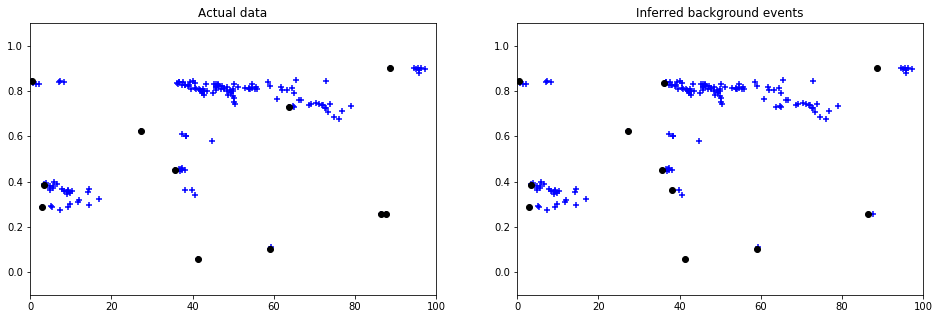

In [308]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(width,5))

ax[0].set(xlim=[0,100], ylim=[-0.1,1.1], title="Actual data")
_ = ax[0].scatter(x=[e.t for e in points], y=[e.loc for e in points], color="blue", marker="+")
_ = ax[0].scatter(x=[e.t for e in backgrounds], y=[e.loc for e in backgrounds], color="black", marker="o")

ax[1].set(xlim=[0,100], ylim=[-0.1,1.1], title="Inferred background events")
_ = ax[1].scatter(x=[e.t for e in triggered_points], y=[e.loc for e in triggered_points], color="blue", marker="+")
_ = ax[1].scatter(x=[e.t for e in background_points], y=[e.loc for e in background_points], color="black", marker="o")

*TODO:* These keep changing, of course...

I think these plots are intuitively explainable:

- We miss a background event at time 40, but it fell in the middle of a clump of triggered events.
- Three triggered event at time circa 70 are classified as background-- but they look like unlikely events, so this seems plausible.

# Iterative approximation for parametric distributions #

Suppose now we do not know the parameters $\mu, \alpha$ and $\sigma$.  We take an iterative, monte carlo approach.

1. Take an initial "guess" of the parameters
2. Use these to form $\mu$ and $g$ and hence form the matrix $p$.
3. For each event, using the probabilities from the matrix, randomly decide if the event is background, or assign it to a "triggering" event.
4. Use the background events to estimate the parameter $\mu$ (e.g. via MLE) and similarly use the triggered events to estimate $\alpha, \sigma$.

See below for calculations of what the MLEs are.

In [309]:
def compute_backgrounds_deltas(causes, points):
    backgrounds, trigger_deltas = [], []
    causes = sample_causality(p_matrix)
    for i, p in enumerate(points):
        c = causes[i]
        if c == i:
            backgrounds.append(p)
        else:
            tp = points[c]
            delta = Event(p.t - tp.t, p.loc - tp.loc)
            trigger_deltas.append(delta)
    return backgrounds, trigger_deltas

def make_estimates(causes, points):
    """Returns MLEs for mu, alpha and sigma."""
    backgrounds, trigger_deltas = compute_backgrounds_deltas(causes, points)
    #background_event_times = np.array([e.t for e in backgrounds])
    #background_event_time_deltas = background_event_times[1:] - background_event_times[:-1]
    #mu = 1 / np.mean(background_event_time_deltas)
    window_size = 100
    mu = len(backgrounds) / window_size
    
    space_points = [e.loc for e in trigger_deltas]
    sigma = np.std(space_points, ddof=1)
    
    # Biased...
    counts = np.empty(len(causes) - 1, dtype=np.int32)
    for i in range(len(causes) - 1):
        counts[i] = sum(c==i for c in causes[i+1:])
    alpha = np.mean(counts)
    
    return mu, alpha, sigma

In [314]:
def sample_causality(p_matrix):
    """Returns a list where entry i is the j<i which caused i, or i if i is background"""
    number_points = p_matrix.shape[0]
    causes = np.empty(number_points, dtype=int)
    for i in range(number_points):
        choices = list(range(i+1))
        probs = p_matrix[:i+1, i]
        c = np.random.choice(choices, p=probs)
        causes[i] = c
    return causes

If we use the _actual_ causality data, and the real parameters to build the probability matrix, then the estimated parameters look as we expect: $\sigma$ is accurate, $\mu$ tends to vary (as the number of background events is small-- our window is too small given the real value of $\mu$) and $\alpha$ tends to be a slight under estimate.  (As $\alpha = 1$ the number of triggered events, per trigger, is small; however, the "self-exciting" nature of the process means that one background event can, in totality, trigger a lot of subsequence events).

In [318]:
p_matrix = make_probability_matrix(points, mu, alpha, sigma)
mu_e, alpha_e, sigma_e = make_estimates(caused_by, points)
mu_e, alpha_e, sigma_e

(0.11, 0.930379746835443, 0.0095279324497049758)

If we feed in the real values, we get close to what we started with, which is good.

In [319]:
p_matrix = make_probability_matrix(points, mu, alpha, sigma)
causes = sample_causality(p_matrix)
mu_e, alpha_e, sigma_e = make_estimates(causes, points)
mu_e, alpha_e, sigma_e

(0.18, 0.91772151898734178, 0.0090528037614543803)

If we now start with values which are fairly far from being correct, then we still converge to a reasonable estimate.

In [320]:
mu_e, alpha_e, sigma_e = 1, 2, 0.5

for _ in range(20):
    p_matrix = make_probability_matrix(points, mu_e, alpha_e, sigma_e)
    causes = sample_causality(p_matrix)
    mu_e, alpha_e, sigma_e = make_estimates(causes, points)

mu_e, alpha_e, sigma_e

(0.12, 0.91772151898734178, 0.0087461142273874207)

# Some calculations #

The offspring have intensity $\alpha \beta(t) = \alpha (1+t)^{-2}$ and so the compensator is
$$ \Lambda^*(t) = \int_0^t \alpha(1+s)^{-2} \ ds = \alpha \big(1 - (1+t)^{-1} \big) = \frac{\alpha t}{1+t} $$
Thus solving $\Lambda^*(t) = s$ gives
$$ t = \frac{s}{\alpha - s} $$

### MLEs for $\mu$, $\sigma$ and $\alpha$ ###

Given (the times of) background events $s_1 < s_2 < \cdots < s_m$ we wish to estimate $\mu$ under the assumption of a constant conditional intensity function $\mu$.  This is straightforward, as under this assumption, the inter-time gaps $(s_2-s_1, s_3-s_2, \cdots, s_m-s_{m-1})$ are iid as exponential random variables.
- The MLE for $\mu$ is then the inverse of the sample mean, see [Wikipedia: Parameter estimation](https://en.wikipedia.org/wiki/Exponential_distribution#Maximum_likelihood).

*However* because we are using a finite window, a better estimate is just the count:
$$ \hat\mu = m / w_{\text{length}} $$

Now consider the "triggered" events, where we are given the differences between the "cause" and "result" events, say $(\Delta t_i, \Delta x_i)_{i=1}^n$.  Because of the form of our assumed distributions, we can treat these separately.

- The $(\Delta x_i)$ come from a centred normal distribution with variance $\sigma^2$.  We estimate this in the usual way: [Wikipedia](https://en.wikipedia.org/wiki/Normal_distribution#Sample_variance)

For the "power law" conditional intensity function $\beta(t) = \alpha (1+t)^{-2}$, we have to think about how to estimate $\alpha$.  The parameter $\alpha$ controls only the total intensity.  For example, if we double $\alpha$, then we expect each event to trigger twice the number of "offspring", but otherwise to have no further change.  As the compensator ($\Lambda^*$ above) converges to $\alpha$ as $t\rightarrow\infty$:

- If we assume we can see the _entire_ process, then an estimate of $\alpha$ is just the number of subsequent events each event triggers.  Notice that our "probability matrix" encodes this information.

If we cannot see the entire process (which is the case) then we might "miss" triggered events because they occur after the end of our window.